In [14]:
from torchvision import models
import torchvision
from torch import nn
from torch.nn import functional as F
import torch
from torchvision import transforms
from torch.utils import data
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt

In [15]:
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

valid_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])


In [16]:
train_data_path = "./train/"
train_data = torchvision.datasets.ImageFolder(root=train_data_path, transform=train_transforms)

In [17]:
val_data_path = "./val/"
val_data = torchvision.datasets.ImageFolder(root=val_data_path, transform=valid_transforms)

In [18]:
batch_size=64
train_data_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_data_loader  = data.DataLoader(val_data, batch_size=batch_size, shuffle=False)

In [19]:
transfer_model = torch.hub.load('pytorch/vision', 'resnet50', pretrained=True)

Using cache found in /home/science/.cache/torch/hub/pytorch_vision_master


In [20]:
for name, param in transfer_model.named_parameters():
    if("bn" not in name):
        param.requires_grad = False

In [21]:
transfer_model.fc = nn.Sequential(
    nn.Linear(transfer_model.fc.in_features,500),
    nn.ReLU(),
    nn.Dropout(), 
    nn.Linear(500,2)
)

In [22]:
sum(p.numel() for p in transfer_model.parameters() if p.requires_grad)

1070942

In [23]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

transfer_model.to(device);

In [24]:
optimizer = optim.Adam(transfer_model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

def find_lr(net, criterion, optimizer, trn_loader, init_value = 1e-8, final_value=10., beta = 0.98):
    num = len(trn_loader)-1
    mult = (final_value / init_value) ** (1/num)
    lr = init_value
    optimizer.param_groups[0]['lr'] = lr
    avg_loss = 0.
    best_loss = 0.
    batch_num = 0
    losses = []
    log_lrs = []
    for data in trn_loader:
        batch_num += 1
        #As before, get the loss for this mini-batch of inputs/outputs
        inputs,labels = data
        inputs, labels = Variable(inputs.to(device)), Variable(labels.to(device))
        optimizer.zero_grad()
        pos, neg = net(labels, inputs)
        loss = criterion(pos.view(-1, 1), neg)

        #Compute the smoothed loss
        avg_loss = beta * avg_loss + (1-beta) *loss.data[0]
        smoothed_loss = avg_loss / (1 - beta**batch_num)
        #Stop if the loss is exploding
        if batch_num > 1 and smoothed_loss > 4 * best_loss:
            return log_lrs, losses
        #Record the best loss
        if smoothed_loss < best_loss or batch_num==1:
            best_loss = smoothed_loss
        #Store the values
        losses.append(smoothed_loss)
        log_lrs.append(torch.log10(torch.FloatTensor([lr]).to(device)))
        #Do the SGD step
        loss.backward()
        optimizer.step()
        #Update the lr for the next step
        lr *= mult
        optimizer.param_groups[0]['lr'] = lr
    return log_lrs, losses

In [47]:
logs, losses = find_lr(transfer_model, loss_fn, optimizer, train_data_loader, device)

TypeError: unsupported operand type(s) for /: 'float' and 'torch.device'

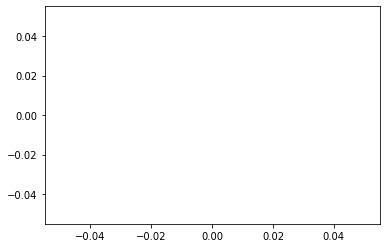

In [44]:
plt.plot(logs, losses)

In [45]:
logs, losses

([], [])

In [48]:
found_lr = 3e-2

In [49]:
optimizer = optimizer.Adam([
    { 
        'params': transfer_model.layer4.parameters(), 
        'lr': found_lr /3
    },
    { 
        'params': transfer_model.layer3.parameters(), 
        'lr': found_lr /9
    },
], lr=found_lr)

AttributeError: 'Adam' object has no attribute 'Adam'

In [ ]:
unfreeze_layers = [transfer_model.layer3, transfer_model.layer4]
for layer in unfreeze_layers:
    for param in layer.parameters():
        param.requires_grad = True

In [25]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu"):
    for epoch in range(epochs):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item()
        training_loss /= len(train_loader)

        model.eval()
        num_correct = 0
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output,targets)
            valid_loss += loss.data.item()
            correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader)

        print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(
            epoch, training_loss,
            valid_loss, 
            num_correct / num_examples
        ))

In [26]:
train(transfer_model, optimizer, torch.nn.CrossEntropyLoss(), train_data_loader, val_data_loader, 20, device)

<ipython-input-25-0300d68d8e22>:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)


Epoch: 0, Training Loss: 0.69, Validation Loss: 0.32, accuracy = 0.84
Epoch: 1, Training Loss: 0.33, Validation Loss: 0.22, accuracy = 0.93
Epoch: 2, Training Loss: 0.23, Validation Loss: 0.18, accuracy = 0.91
Epoch: 3, Training Loss: 0.16, Validation Loss: 0.17, accuracy = 0.92
Epoch: 4, Training Loss: 0.12, Validation Loss: 0.17, accuracy = 0.93
Epoch: 5, Training Loss: 0.12, Validation Loss: 0.17, accuracy = 0.91
Epoch: 6, Training Loss: 0.10, Validation Loss: 0.18, accuracy = 0.91
Epoch: 7, Training Loss: 0.10, Validation Loss: 0.15, accuracy = 0.92
Epoch: 8, Training Loss: 0.10, Validation Loss: 0.16, accuracy = 0.92
Epoch: 9, Training Loss: 0.07, Validation Loss: 0.15, accuracy = 0.94
Epoch: 10, Training Loss: 0.06, Validation Loss: 0.13, accuracy = 0.94
Epoch: 11, Training Loss: 0.03, Validation Loss: 0.14, accuracy = 0.94
Epoch: 12, Training Loss: 0.03, Validation Loss: 0.13, accuracy = 0.94
Epoch: 13, Training Loss: 0.08, Validation Loss: 0.14, accuracy = 0.93
Epoch: 14, Train

In [29]:
train_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

valid_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])


train_data_path = "./train/"
train_data = torchvision.datasets.ImageFolder(root=train_data_path, transform=train_transforms)

val_data_path = "./val/"
val_data = torchvision.datasets.ImageFolder(root=val_data_path, transform=valid_transforms)

batch_size=64
train_data_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_data_loader  = data.DataLoader(val_data, batch_size=batch_size, shuffle=False)

In [30]:
transfer_model.to(device);

optimizer = optim.Adam(transfer_model.parameters(), lr=0.0001)
loss_fn = torch.nn.CrossEntropyLoss()
train(transfer_model, optimizer, torch.nn.CrossEntropyLoss(), train_data_loader, val_data_loader, 20, device)

<ipython-input-25-0300d68d8e22>:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)


Epoch: 0, Training Loss: 0.09, Validation Loss: 0.04, accuracy = 0.99
Epoch: 1, Training Loss: 0.09, Validation Loss: 0.03, accuracy = 0.99
Epoch: 2, Training Loss: 0.07, Validation Loss: 0.03, accuracy = 0.99
Epoch: 3, Training Loss: 0.06, Validation Loss: 0.03, accuracy = 0.99
Epoch: 4, Training Loss: 0.04, Validation Loss: 0.03, accuracy = 0.99
Epoch: 5, Training Loss: 0.04, Validation Loss: 0.03, accuracy = 0.99
Epoch: 6, Training Loss: 0.03, Validation Loss: 0.02, accuracy = 0.99
Epoch: 7, Training Loss: 0.03, Validation Loss: 0.02, accuracy = 0.99
Epoch: 8, Training Loss: 0.04, Validation Loss: 0.02, accuracy = 0.99
Epoch: 9, Training Loss: 0.03, Validation Loss: 0.02, accuracy = 0.99
Epoch: 10, Training Loss: 0.03, Validation Loss: 0.02, accuracy = 0.99
Epoch: 11, Training Loss: 0.03, Validation Loss: 0.02, accuracy = 0.99
Epoch: 12, Training Loss: 0.03, Validation Loss: 0.02, accuracy = 0.99
Epoch: 13, Training Loss: 0.03, Validation Loss: 0.02, accuracy = 0.99
Epoch: 14, Train

In [31]:
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

valid_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])


train_data_path = "./train/"
train_data = torchvision.datasets.ImageFolder(root=train_data_path, transform=train_transforms)

val_data_path = "./val/"
val_data = torchvision.datasets.ImageFolder(root=val_data_path, transform=valid_transforms)

batch_size=64
train_data_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_data_loader  = data.DataLoader(val_data, batch_size=batch_size, shuffle=False)

In [32]:
transfer_model.to(device);

optimizer = optim.Adam(transfer_model.parameters(), lr=0.0001)
loss_fn = torch.nn.CrossEntropyLoss()
train(transfer_model, optimizer, torch.nn.CrossEntropyLoss(), train_data_loader, val_data_loader, 20, device)

<ipython-input-25-0300d68d8e22>:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)


RuntimeError: CUDA out of memory. Tried to allocate 256.00 MiB (GPU 0; 7.93 GiB total capacity; 6.89 GiB already allocated; 175.88 MiB free; 6.98 GiB reserved in total by PyTorch)

In [ ]:
predictions = [m[i].fit(input) for i in models]
avg_prediction = torch.stack(b).mean(0).argmax()

In [27]:
def _random_colour_space(x):
    output = x.convert("HSV")
    return output

In [ ]:
colour_transform = transforms.Lambda(lambda x: _random_colour_space(x))

In [ ]:
random_colour_transform = torchvision.transforms.RandomApply([colour_transform], p=0.5)

In [ ]:
class Noise():
    """Adds gaussian noise to a tensor.

        >>> transforms.Compose([
        >>>     transforms.ToTensor(),
        >>>     Noise(0.1, 0.05)),
        >>> ])

    """
    def __init__(self, mean, stddev):
        self.mean = mean
        self.stddev = stddev

    def __call__(self, tensor):
        noise = torch.zeros_like(tensor).normal_(self.mean, self.stddev)
        return tensor.add_(noise)

    def __repr__(self):
        repr = f"{self.__class__.__name__  }(mean={self.mean},
               stddev={self.stddev})"
        return repr

In [ ]:
transforms.Compose([Noise(0.1, 0.05))])
>> Compose(
    Noise(mean=0.1,sttdev=0.05)
)